# Customer Behavior Analysis (EDA)

This notebook focuses on understanding customer behavior using cleaned retail transaction data.

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 6)

### 1. Customer Lifetime Value (CLV)

In [16]:
df = pd.read_csv('../data/processed/online_retail_cleaned.csv')
clv_df = df.groupby("CustomerID")["TotalPrice"].sum().reset_index(name="CLV")

clv_df = clv_df[clv_df['CustomerID'] != 'ANONYMOUS']
clv_df['CLV'].describe()

count      4372.000000
mean       1893.531433
std        8218.696204
min       -4287.630000
25%         291.795000
50%         644.070000
75%        1608.335000
max      279489.020000
Name: CLV, dtype: float64

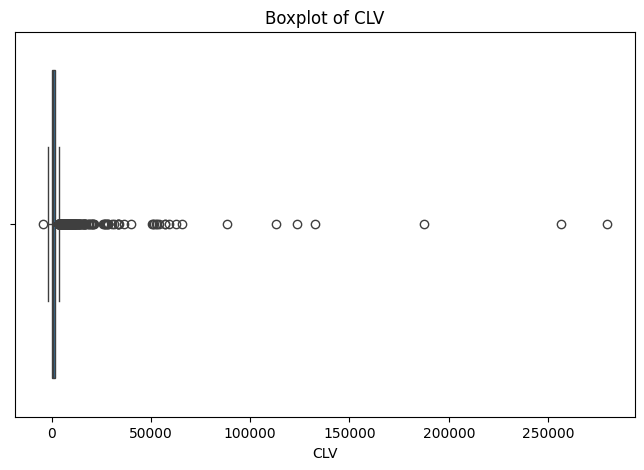

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(x=clv_df['CLV'])
plt.title('Boxplot of CLV')
plt.show()

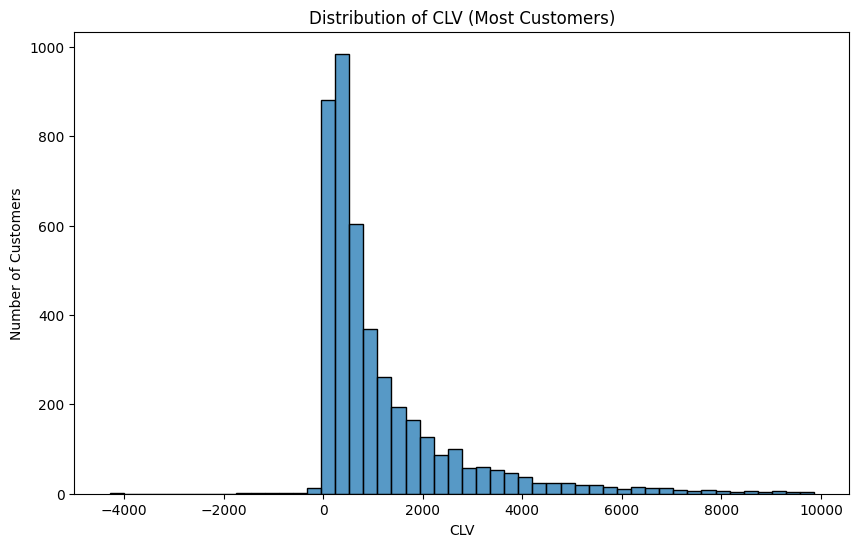

In [18]:
# Focus on CLV ≤ 5000 (covers 75% of data plus a bit more)
plt.figure(figsize=(10,6))
sns.histplot(clv_df[clv_df['CLV'] <= 10000]['CLV'], bins=50)
plt.title('Distribution of CLV (Most Customers)')
plt.xlabel('CLV')
plt.ylabel('Number of Customers')
plt.show()


In [19]:
# Question: How can we categorize customers based on CLV?
# Using quantiles for segmentation
low_thresh = clv_df['CLV'].quantile(0.33)
high_thresh = clv_df['CLV'].quantile(0.66)

def clv_segment(clv):
    if clv <= low_thresh:
        return 'Low-value'
    elif clv <= high_thresh:
        return 'Medium-value'
    else:
        return 'High-value'

clv_df['Segment'] = clv_df['CLV'].apply(clv_segment)

# Count of customers in each segment
clv_df['Segment'].value_counts()

Segment
High-value      1487
Low-value       1443
Medium-value    1442
Name: count, dtype: int64

In [20]:
# Question: Who are the top 10 customers by CLV?
clv_df.sort_values(by='CLV', ascending=False).head(10)

,CustomerID,CLV,Segment
1703,14646.0,279489.02,High-value
4233,18102.0,256438.49,High-value
3758,17450.0,187322.17,High-value
1895,14911.0,132458.73,High-value
55,12415.0,123725.45,High-value
1345,14156.0,113214.59,High-value
3801,17511.0,88125.38,High-value
3202,16684.0,65892.08,High-value
1005,13694.0,62690.54,High-value
2192,15311.0,59284.19,High-value


#### Results/Interpretation:

- The customers are fairly evenly distributed across segments: High-value (1,487), Medium-value (1,442), Low-value (1,443).
- CLV is highly skewed: while most customers fall in the low to medium range, a small number of high-value customers contribute disproportionately to revenue (max CLV = 279,489 vs. median = 644).
- This indicates that targeting high-value customers (VIPs) for retention or special offers could have a significant impact on overall revenue, while growth strategies can focus on converting low-value customers into medium or high-value.

### 2. Average Order Value (AOV)

In [21]:
df = pd.read_csv('../data/processed/online_retail_cleaned.csv')
df = df[df['CustomerID'] != 'ANONYMOUS'].reset_index(drop=True)

In [22]:
# Question: How to calculate AOV for each customer?
# Calculate total spend per customer
total_spend = df.groupby('CustomerID')['TotalPrice'].sum()

# Count number of orders per customer
num_orders = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Calculate AOV = total spend / number of orders
aov_df = (total_spend / num_orders).reset_index()
aov_df.columns = ['CustomerID', 'AOV']

# Question: What are the key statistics for AOV?
aov_df['AOV'].describe()

count    4372.000000
mean      314.492693
std       360.855433
min     -4287.630000
25%       151.430000
50%       235.154111
75%       366.518750
max      6207.670000
Name: AOV, dtype: float64

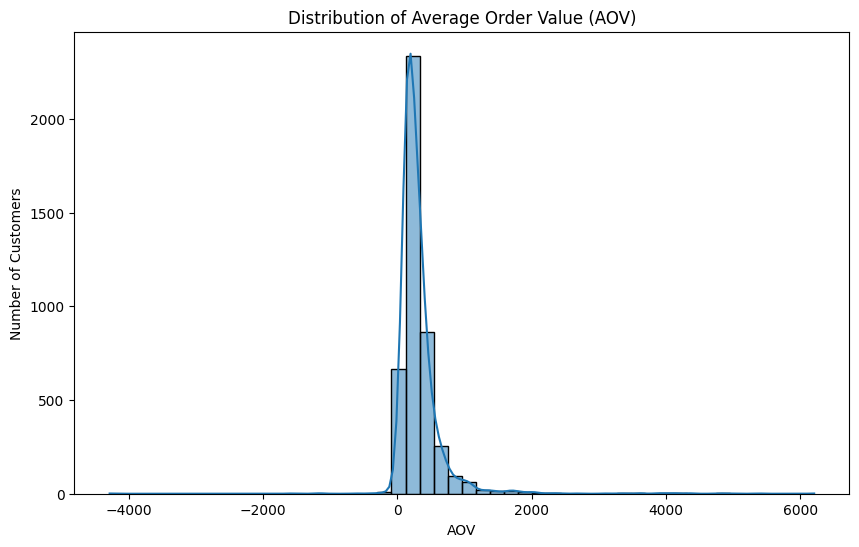

In [23]:
# Question: How is AOV distributed across customers?
plt.figure(figsize=(10,6))
sns.histplot(aov_df['AOV'], bins=50, kde=True)
plt.title('Distribution of Average Order Value (AOV)')
plt.xlabel('AOV')
plt.ylabel('Number of Customers')
plt.show()


In [24]:
# Question: Who are the customers with highest AOV?
high_aov_threshold = aov_df['AOV'].quantile(0.90)  # top 10% AOV
high_aov_customers = aov_df[aov_df['AOV'] >= high_aov_threshold]

high_aov_customers.sort_values(by='AOV', ascending=False).head(10)


,CustomerID,AOV
10,12357.0,6207.670000
2522,15749.0,5383.975000
282,12688.0,4873.810000
55,12415.0,4758.671154
333,12752.0,4366.780000
4347,18251.0,4314.720000
4233,18102.0,4136.104677
2698,16000.0,4131.233333
27,12378.0,4008.620000
73,12435.0,3914.945000


### 3. Customer Purchase Frequency

In [25]:
# Question: How many orders does each customer make?
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

# Combine CLV and frequency for segmentation
customer_df = clv_df.merge(frequency_df, on='CustomerID', how='inner')
customer_df.to_csv("../data/processed/customer_behavior_analysis.csv", index=False)


In [26]:
# Question: How can we categorize customers based on CLV and Frequency?

clv_median = customer_df['CLV'].median()
freq_median = customer_df['Frequency'].median()

def behavioral_segment(row):
    if row['CLV'] > clv_median and row['Frequency'] > freq_median:
        return 'Loyal Customers'
    elif row['CLV'] > clv_median and row['Frequency'] <= freq_median:
        return 'Premium Occasional Buyers'
    elif row['CLV'] <= clv_median and row['Frequency'] > freq_median:
        return 'Frequent Low-Value Buyers'
    else:
        return 'One-time Buyers'

customer_df['Segment'] = customer_df.apply(behavioral_segment, axis=1)
customer_df['Segment'].value_counts()


Segment
One-time Buyers              2008
Loyal Customers              1574
Premium Occasional Buyers     612
Frequent Low-Value Buyers     178
Name: count, dtype: int64

In [27]:
# Question: How much revenue does each segment contribute?
segment_revenue = customer_df.groupby('Segment')['CLV'].sum().sort_values(ascending=False)
segment_revenue

Segment
Loyal Customers              6874904.541
Premium Occasional Buyers     755483.511
One-time Buyers               568265.062
Frequent Low-Value Buyers      79866.310
Name: CLV, dtype: float64

#### Results/Interpretation:

- A small group of high-value loyal and occasional premium customers drives the majority of revenue, highlighting the importance of retention and targeted marketing strategies for these segments. 
- One-time buyers represent a large portion of the customer base but generate relatively low revenue, suggesting potential for growth if they can be converted into repeat buyers.